In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# 1. Loading Datasets

In [3]:
import lightgbm as lgb
from xgboost import XGBRegressor    

In [4]:
BASE = "/kaggle/input/Cinema_Audience_Forecasting_challenge/"
OUT_DIR = "/kaggle/working"
output_path = os.path.join(OUT_DIR, "submission.csv")
date_cutoff = pd.Timestamp("2024-01-15")
SEED = 42

In [5]:
df_visits = pd.read_csv(os.path.join(BASE, "booknow_visits/booknow_visits.csv"), parse_dates=["show_date"])
df_bookings = pd.read_csv(os.path.join(BASE, "booknow_booking/booknow_booking.csv"))
date_info = pd.read_csv(os.path.join(BASE, "date_info/date_info.csv"), parse_dates=["show_date"])
sample_submission = pd.read_csv(os.path.join(BASE, "sample_submission/sample_submission.csv"))

print("Loaded: audience_visits", df_visits.shape, "date_info", date_info.shape, "bookings", df_bookings.shape, "sample_submission", sample_submission.shape)

Loaded: audience_visits (214046, 3) date_info (547, 2) bookings (68336, 4) sample_submission (38062, 2)


# 2. EDA

# 2.1. Quick Stats

In [6]:
print("booknow_visits Describe:")
print(df_visits.describe())
print("\ndate_info Describe:")
print(date_info.describe())
print("\nbooknow_bookings Describe:")
print(df_bookings.describe())

booknow_visits Describe:
                           show_date  audience_count
count                         214046   214046.000000
mean   2023-09-13 04:07:24.285807360       41.616568
min              2023-01-01 00:00:00        2.000000
25%              2023-07-09 00:00:00       18.000000
50%              2023-09-25 00:00:00       34.000000
75%              2023-12-11 00:00:00       58.000000
max              2024-02-28 00:00:00     1350.000000
std                              NaN       32.834918

date_info Describe:
                 show_date
count                  547
mean   2023-10-01 00:00:00
min    2023-01-01 00:00:00
25%    2023-05-17 12:00:00
50%    2023-10-01 00:00:00
75%    2024-02-14 12:00:00
max    2024-06-30 00:00:00

booknow_bookings Describe:
       tickets_booked
count    68336.000000
mean         4.425808
std          4.808945
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        100.000000


In [7]:
print("booknow_visits Info:")
print(df_visits.info())
print("\ndate_info Info:")
print(date_info.info())
print("\nbooknow_bookings Info:")
print(df_bookings.info())

booknow_visits Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  214046 non-null  object        
 1   show_date        214046 non-null  datetime64[ns]
 2   audience_count   214046 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.9+ MB
None

date_info Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   show_date    547 non-null    datetime64[ns]
 1   day_of_week  547 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.7+ KB
None

booknow_bookings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column 

In [8]:
print("Unique Theaters and Dates:")
print(f"Unique theaters in booknow_visits: {df_visits['book_theater_id'].nunique()}")
print(f"Unique show_date in booknow_visits: {df_visits['show_date'].nunique()}")

print(f"\nUnique theaters in booknow_bookings: {df_bookings['book_theater_id'].nunique()}")
print(f"Unique show_datetime entries in booknow_bookings: {df_bookings['show_datetime'].nunique()}")

print(f"\nUnique dates in date_info: {date_info['show_date'].nunique()}")

Unique Theaters and Dates:
Unique theaters in booknow_visits: 826
Unique show_date in booknow_visits: 424

Unique theaters in booknow_bookings: 301
Unique show_datetime entries in booknow_bookings: 3866

Unique dates in date_info: 547


In [9]:
def missing_summary(df):
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    return pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_percent.round(2)
    }).sort_values(by='Missing %', ascending=False)

print("Missing Values in booknow_visits:")
display(missing_summary(df_visits))

print("\nMissing Values in date_info:")
display(missing_summary(date_info))

print("\nMissing Values in booknow_bookings:")
display(missing_summary(df_bookings))

Missing Values in booknow_visits:


,Missing Count,Missing %
book_theater_id,0,0.0
show_date,0,0.0
audience_count,0,0.0



Missing Values in date_info:


,Missing Count,Missing %
show_date,0,0.0
day_of_week,0,0.0



Missing Values in booknow_bookings:


,Missing Count,Missing %
book_theater_id,0,0.0
show_datetime,0,0.0
booking_datetime,0,0.0
tickets_booked,0,0.0


# 2.2. Quick Plots

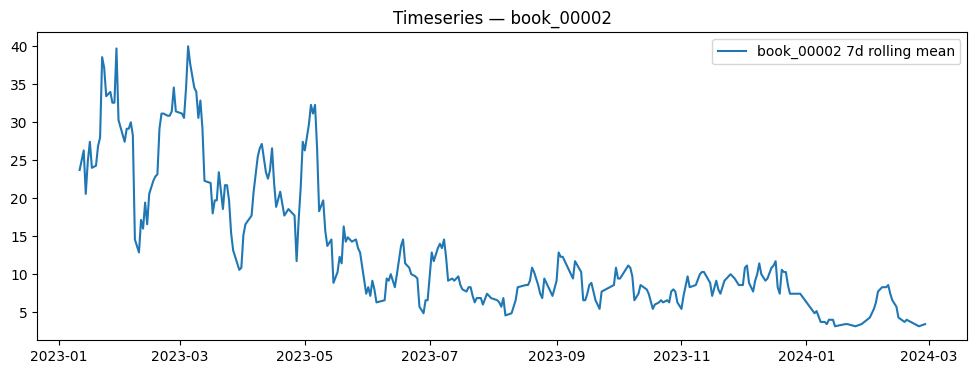

In [10]:
t0 = df_visits['book_theater_id'].unique()[1]
plt.figure(figsize=(12,4))
tmp = df_visits[df_visits['book_theater_id']==t0].set_index('show_date').sort_index()
plt.plot(tmp['audience_count'].rolling(7).mean(), label=f"{t0} 7d rolling mean")
plt.title(f"Timeseries — {t0}")
plt.legend()
plt.show()

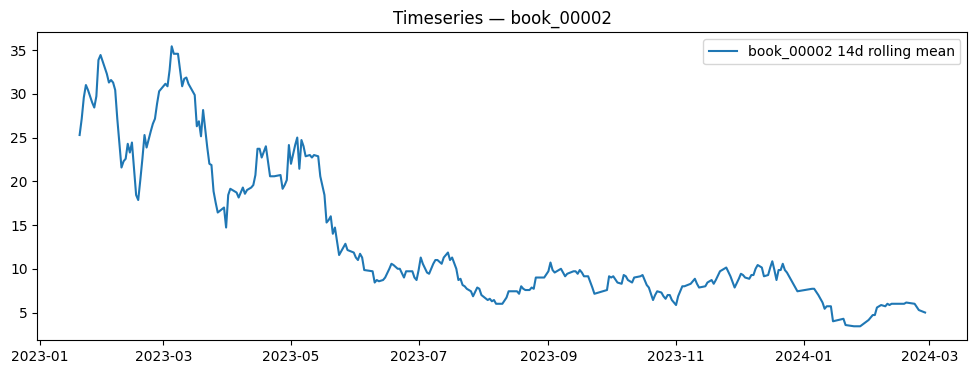

In [11]:
t0 = df_visits['book_theater_id'].unique()[1]
plt.figure(figsize=(12,4))
tmp = df_visits[df_visits['book_theater_id']==t0].set_index('show_date').sort_index()
plt.plot(tmp['audience_count'].rolling(14).mean(), label=f"{t0} 14d rolling mean")
plt.title(f"Timeseries — {t0}")
plt.legend()
plt.show()

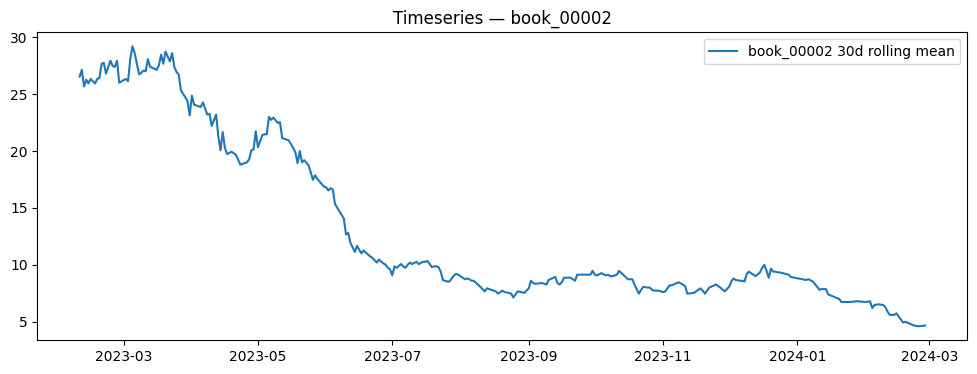

In [12]:
t0 = df_visits['book_theater_id'].unique()[1]
plt.figure(figsize=(12,4))
tmp = df_visits[df_visits['book_theater_id']==t0].set_index('show_date').sort_index()
plt.plot(tmp['audience_count'].rolling(30).mean(), label=f"{t0} 30d rolling mean")
plt.title(f"Timeseries — {t0}")
plt.legend()
plt.show()

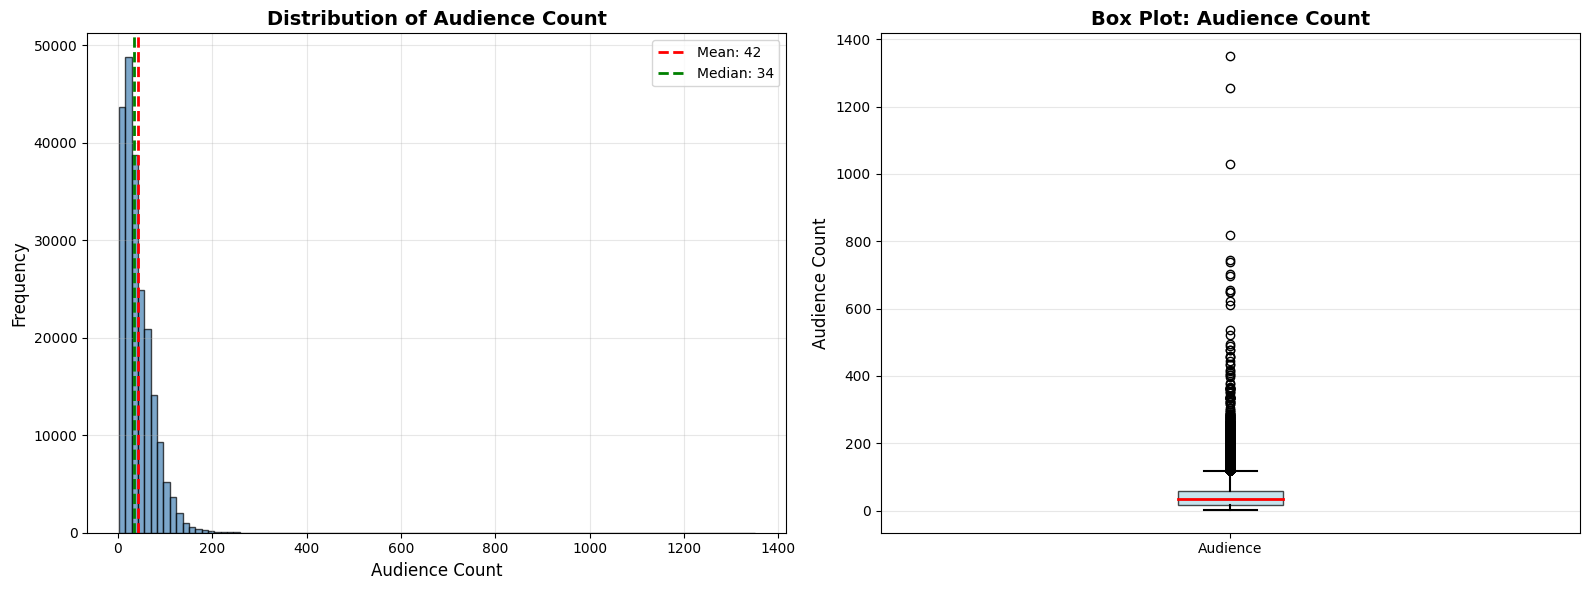


AUDIENCE COUNT DISTRIBUTION:
count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(df_visits['audience_count'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Audience Count', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Audience Count', fontsize=14, fontweight='bold')
axes[0].axvline(df_visits['audience_count'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {df_visits["audience_count"].mean():.0f}')
axes[0].axvline(df_visits['audience_count'].median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {df_visits["audience_count"].median():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].boxplot(df_visits['audience_count'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))
axes[1].set_ylabel('Audience Count', fontsize=12)
axes[1].set_title('Box Plot: Audience Count', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(['Audience'])
plt.tight_layout()
plt.show()

print("\nAUDIENCE COUNT DISTRIBUTION:")
print(df_visits['audience_count'].describe())

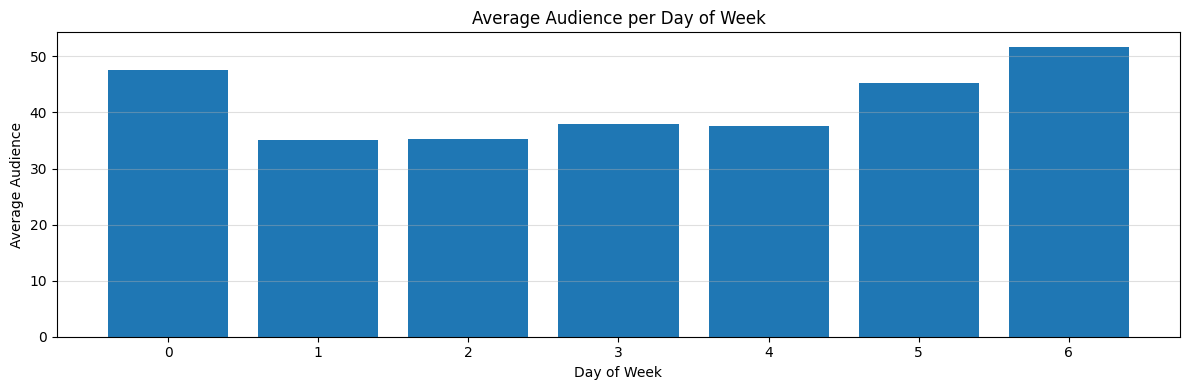

In [14]:
temp_df = df_visits.copy()

#temp features for vis
temp_df["dow"] = temp_df["show_date"].dt.dayofweek
temp_df["is_weekend"] = temp_df["dow"].isin(["Saturday", "Sunday"]).astype(int)

avg_dow = temp_df.groupby("dow")["audience_count"].mean()

plt.figure(figsize=(12,4))
plt.bar(avg_dow.index, avg_dow.values)
plt.title("Average Audience per Day of Week")
plt.xlabel("Day of Week"); plt.ylabel("Average Audience")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

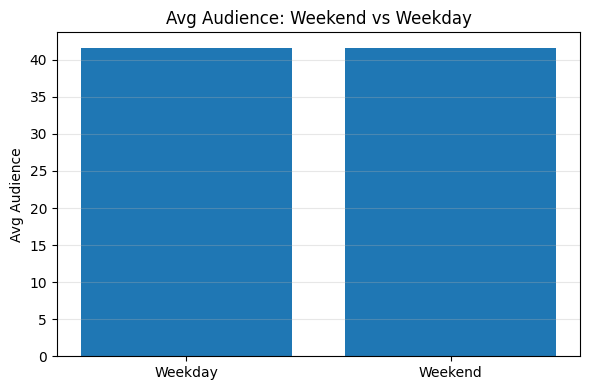

In [15]:
v = temp_df.groupby("is_weekend")["audience_count"].mean()
x_labels = ["Weekday", "Weekend"]

plt.figure(figsize=(6,4))
plt.bar(x_labels, v.values)
plt.title("Avg Audience: Weekend vs Weekday")
plt.ylabel("Avg Audience")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
#note : 2 days of weekend == 5 weekdays

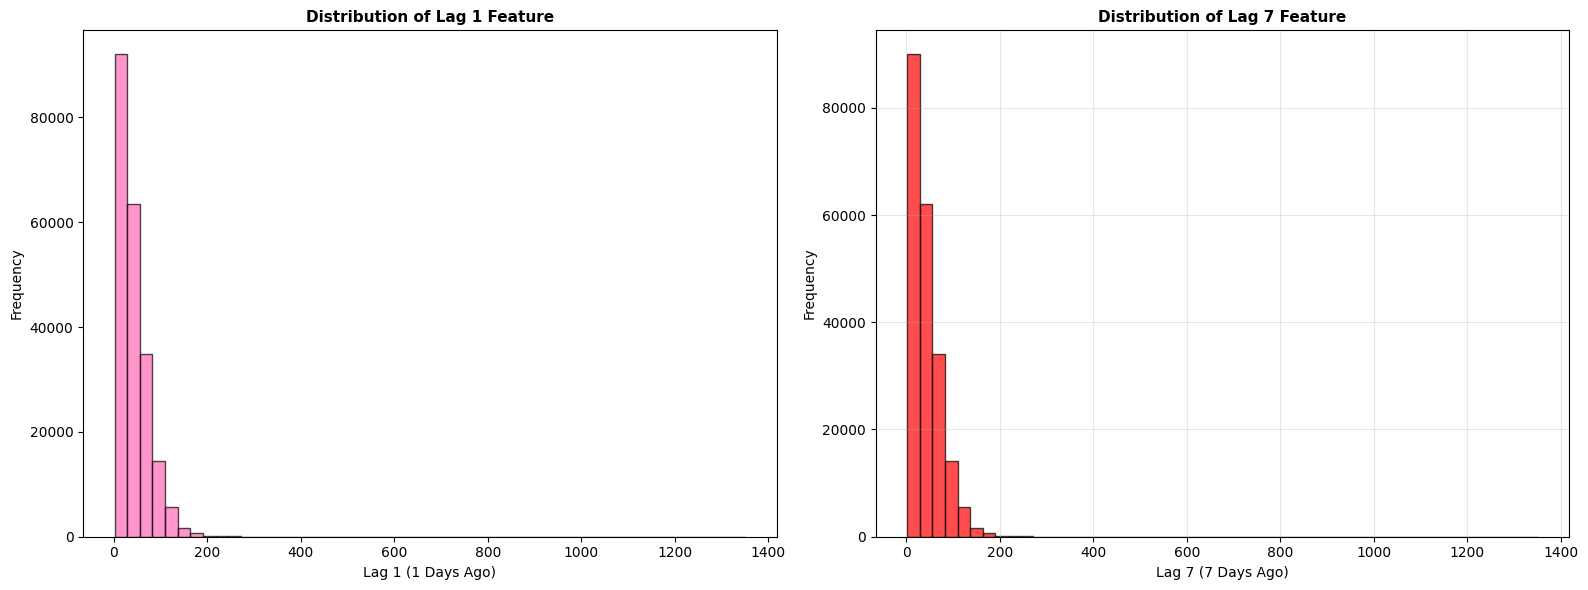

In [16]:
temp_df["lag_1"] = temp_df.groupby("book_theater_id")["audience_count"].shift(1)
temp_df["lag_7"] = temp_df.groupby("book_theater_id")["audience_count"].shift(7)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].hist(temp_df['lag_1'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='hotpink')
axes[0].set_xlabel('Lag 1 (1 Days Ago)', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].set_title('Distribution of Lag 1 Feature', fontsize=11, fontweight='bold')

axes[1].hist(temp_df['lag_7'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1].set_xlabel('Lag 7 (7 Days Ago)', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].set_title('Distribution of Lag 7 Feature', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Data Cleaning & Preprocessing

In [17]:
vis = df_visits.drop_duplicates().copy()
vis = vis.sort_values(["book_theater_id","show_date","audience_count"])
vis = vis.groupby(["book_theater_id","show_date"], as_index=False).agg({"audience_count":"max"})


vis.loc[vis["audience_count"] < 0, "audience_count"] = np.nan
med_per_theater = vis.groupby("book_theater_id")["audience_count"].transform("median")
vis["audience_count"] = vis["audience_count"].fillna(med_per_theater).fillna(vis["audience_count"].median())

# removing extreme spikes (0.5% - 99.5%)
def outlier_handler(s, low=0.005, high=0.995):
    if s.dropna().empty:
        return s
    min_q = s.quantile(low)
    max_q = s.quantile(high)
    return s.clip(lower= min_q, upper=max_q)

vis = vis.sort_values(["book_theater_id","show_date"])
vis["audience_count"] = vis.groupby("book_theater_id")["audience_count"].transform(lambda s: outlier_handler(s))
print("Post cleaning :", vis.shape, "min/max:", vis["audience_count"].min(), vis["audience_count"].max())


Post cleaning : (213871, 3) min/max: 2.0 650.0


# 4. Feature Engineering

In [18]:
df = vis.copy().sort_values(["book_theater_id","show_date"]).reset_index(drop=True)
df["dow"] = df["show_date"].dt.dayofweek
df["month"] = df["show_date"].dt.month
df["year"] = df["show_date"].dt.year
df["is_weekend"] = df["dow"].isin([5,6]).astype(int)

df_bookings["show_date"] = pd.to_datetime(pd.to_datetime(df_bookings["show_datetime"]).dt.date)
book_agg = df_bookings.groupby(["book_theater_id","show_date"])["tickets_booked"].sum().reset_index()
df = df.merge(book_agg, on=["book_theater_id","show_date"], how="left")
df["tickets_booked"] = df["tickets_booked"].fillna(0.0)

grp = df.groupby("book_theater_id")["audience_count"]
df["lag_1"]  = grp.shift(1)
df["lag_2"]  = grp.shift(2)
df["lag_7"]  = grp.shift(7)
df["lag_14"] = grp.shift(14)

def past_roll(s, w):
    return s.shift(1).rolling(w, min_periods=1).mean()

df["rolling_3"]  = grp.apply(lambda s: past_roll(s, 3)).reset_index(level=0, drop=True)
df["rolling_5"]  = grp.apply(lambda s: past_roll(s, 5)).reset_index(level=0, drop=True)
df["rolling_7"]  = grp.apply(lambda s: past_roll(s, 7)).reset_index(level=0, drop=True)
df["rolling_14"] = grp.apply(lambda s: past_roll(s, 14)).reset_index(level=0, drop=True)
df["rolling_30"] = grp.apply(lambda s: past_roll(s, 30)).reset_index(level=0, drop=True)

# ema
df["ema_7"] = grp.apply(lambda s: s.shift(1).ewm(span=7, min_periods=1, adjust=False).mean()).reset_index(level=0, drop=True)

# deltas/momentum
df["diff1"] = df["lag_1"] - df["lag_2"]
df["diff7"] = df["lag_7"] - df["lag_14"]
df["momentum"] = (df["rolling_7"] - df["rolling_14"]) / (df["rolling_14"].abs() + 1)

# global mean to impute
global_mean = df["audience_count"].mean()
fill_cols = ["lag_1","lag_2","lag_7","lag_14","rolling_3","rolling_5","rolling_7","rolling_14","rolling_30","ema_7","diff1","diff7","momentum"]
for c in fill_cols:
    df[c] = df[c].fillna(global_mean)


# 5. Train/validation split (timebased)

In [19]:
# split train/val by date
df = df.sort_values(["book_theater_id","show_date"]).reset_index(drop=True)
train_df = df[df["show_date"] < date_cutoff].copy()
val_df   = df[df["show_date"] >= date_cutoff].copy()

# Used features
active_features = [
    "lag_1","lag_2","lag_7","lag_14",
    "rolling_3","rolling_5","rolling_7","rolling_14","rolling_30",
    "ema_7","momentum","diff1","diff7",
    "tickets_booked","dow","is_weekend","month"
]
target = "audience_count"

print("Train rows:", len(train_df), "Val rows:", len(val_df))


Train rows: 182197 Val rows: 31674


<Axes: >

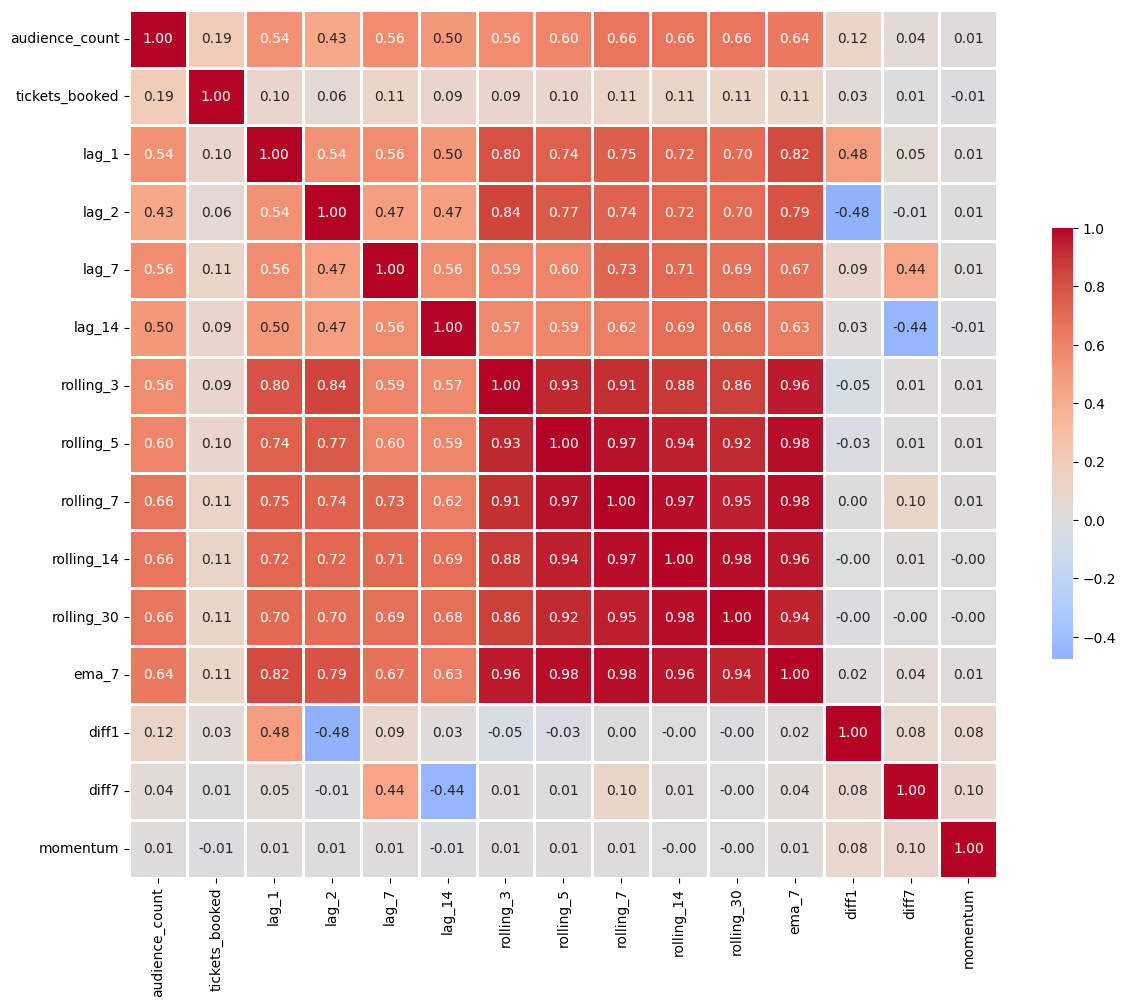

In [20]:
Corr_x = df[df.select_dtypes(include="float").columns].corr()
plt.figure(figsize=(14,14))
sns.heatmap(Corr_x,annot=True,square=True,linewidths=1, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={"shrink": 0.4})

# 6. Model Training

In [21]:
models = {}
val_preds = pd.DataFrame(index=val_df.index)
scores = []

X_train = train_df[active_features].astype(float).values
y_train = train_df[target].astype(float).values
X_val = val_df[active_features].astype(float).values
y_val = val_df[target].astype(float).values

In [22]:
print("Training LightGBM…")

t0 = time.time()

lgbm = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=500,
    min_child_samples=20,
    feature_fraction=0.8,
    subsample=0.8,
    subsample_freq=5,
    random_state=SEED,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

lgb_val_pred = lgbm.predict(X_val)

t1 = time.time()

models["lgb"] = lgbm
val_preds["lgb"] = lgb_val_pred

scores.append((
    "lgb",
    r2_score(y_val, lgb_val_pred),
    mean_squared_error(y_val, lgb_val_pred, squared=False),
    t1 - t0
))

print("LightGBM DONE ✔")

print("Training XGBoost…")

t0 = time.time()

xgbm = XGBRegressor(
        n_estimators=900,
        learning_rate=0.06,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        verbosity=0
    )
xgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
xgb_val_pred = xgbm.predict(X_val)

t1 = time.time()
models["xgb"] = xgbm
val_preds["xgb"] = xgb_val_pred

scores.append((
    "xgb",
    r2_score(y_val, xgb_val_pred),
    mean_squared_error(y_val, xgb_val_pred, squared=False),
    t1 - t0
))

print("XGBoost/HGBR done.")

print("Training Random Forest…(Will take a few mins)")

t0 = time.time()
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=SEED
)
rf.fit(X_train, y_train)
rf_val_pred = rf.predict(X_val)
t1 = time.time()

models["rf"] = rf
val_preds["rf"] = rf_val_pred

scores.append((
    "rf",
    r2_score(y_val, rf_val_pred),
    mean_squared_error(y_val, rf_val_pred, squared=False),
    t1 - t0
))

print("Random Forest done.")

print("Training Ridge…")

t0 = time.time()
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_val_pred = ridge_model.predict(X_val)
t1 = time.time()

models["ridge"] = ridge_model
val_preds["ridge"] = ridge_val_pred

scores.append((
    "ridge",
    r2_score(y_val, ridge_val_pred),
    mean_squared_error(y_val, ridge_val_pred, squared=False),
    t1 - t0
))

print("Ridge done.")

Training LightGBM…
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3318
[LightGBM] [Info] Number of data points in the train set: 182197, number of used features: 17
[LightGBM] [Info] Start training from score 41.779276
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
LightGBM DONE ✔
Training XGBoost…
XGBoost/HGBR done.
Training Random Forest…(Will take a few mins)
Random Forest done.
Training Ridge…
Ridge done.


In [23]:
#RESULTS
results = pd.DataFrame(
    scores,
    columns=["model", "r2_val", "rmse_val", "time_sec"]
).sort_values("r2_val", ascending=False).reset_index(drop=True)

print("\n===== MODEL COMP(VAL) =====")
print(results)


===== MODEL COMP(VAL) =====
   model    r2_val   rmse_val   time_sec
0    lgb  0.574745  19.746979   5.520153
1     rf  0.573070  19.785822  94.921471
2    xgb  0.572616  19.796343  23.389320
3  ridge  0.473381  21.974759   0.053368



=== Results ===
Final feature set contains 17 features as specified


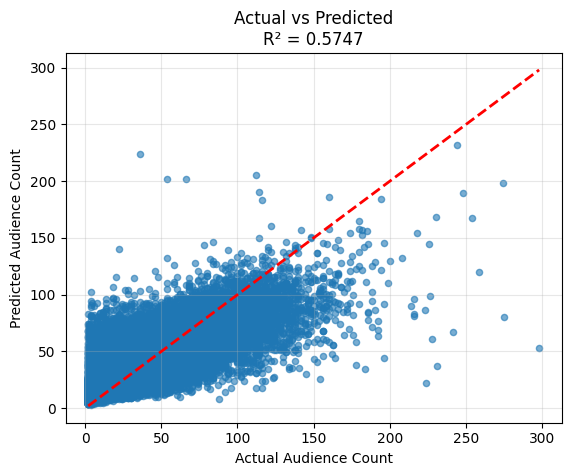

In [24]:
print("\n=== Results ===")
print(f"Final feature set contains {len(active_features)} features as specified")

plt.scatter(y_val, val_preds["lgb"], alpha=0.6, s=20)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Audience Count')
plt.ylabel('Predicted Audience Count')
plt.title(f'Actual vs Predicted\nR² = {results.loc[0,"r2_val"]:.4f}')
plt.grid(True, alpha=0.3)

plt.show()

In [25]:
def feature_importances(m, f_names, topn=15):
    if hasattr(m, "feature_importance"):
        try:
            imp = m.feature_importance(importance_type="gain")
        except Exception:
            imp = m.feature_importance()
    elif hasattr(m, "feature_importances_"):
        imp = m.feature_importances_
    else:
        print("No importances for model:", type(m))
        return
    imp_df = pd.DataFrame({"feature": f_names, "importance": imp})
    imp_df = imp_df.sort_values("importance", ascending=False).head(topn)
    print(imp_df.to_string(index=False))

print("Top features for LGB:")
feature_importances(models["lgb"], active_features,3)
print("\nTop features for XGB:")
feature_importances(models["xgb"], active_features,3)
print("\nTop features for RF:")
feature_importances(models["rf"], active_features,3)


Top features for LGB:
  feature  importance
    lag_7        1202
rolling_5        1140
      dow        1134

Top features for XGB:
   feature  importance
rolling_30    0.293006
rolling_14    0.184497
is_weekend    0.135345

Top features for RF:
   feature  importance
rolling_30    0.560946
rolling_14    0.187398
       dow    0.048995


# 7. Hyperparameter Tuning

In [26]:
# Hyperparameter Tuning 
param_dist = {
    'model__n_estimators': [700,800],
    'model__learning_rate': [0.06,0.05]
}

hxgbm = XGBRegressor(
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        verbosity=0
        )

grid_search = GridSearchCV(
    hxgbm,
    param_grid=param_dist,
    cv=2,
    scoring= 'r2',
    verbose=2,
    n_jobs=-1
)

t0 = time.time()
grid_search.fit(X_train, y_train)
t1 = time.time()
print("Best Parameters:", grid_search.best_params_)
print("Best R2:", grid_search.best_score_)
print("Time:", t1 - t0)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Parameters: {'model__learning_rate': 0.06, 'model__n_estimators': 700}
Best R2: 0.5253417658860703
Time: 40.442644357681274


In [27]:
hxgb_val_pred = grid_search.predict(X_val)
t1 = time.time()

models["hpt"] = grid_search
val_preds["hpt"] = hxgb_val_pred

scores.append((
    "hpt",
    r2_score(y_val, ridge_val_pred),
    mean_squared_error(y_val, ridge_val_pred, squared=False),
    t1 - t0
))

In [28]:
#RESULTS
results2 = pd.DataFrame(
    scores,
    columns=["model", "r2_val", "rmse_val", "time_sec"]
).sort_values("r2_val", ascending=False).reset_index(drop=True)

print("\n===== MODEL COMP(VAL) =====")
print(results2)


===== MODEL COMP(VAL) =====
   model    r2_val   rmse_val   time_sec
0    lgb  0.574745  19.746979   5.520153
1     rf  0.573070  19.785822  94.921471
2    xgb  0.572616  19.796343  23.389320
3  ridge  0.473381  21.974759   0.053368
4    hpt  0.473381  21.974759  40.727131


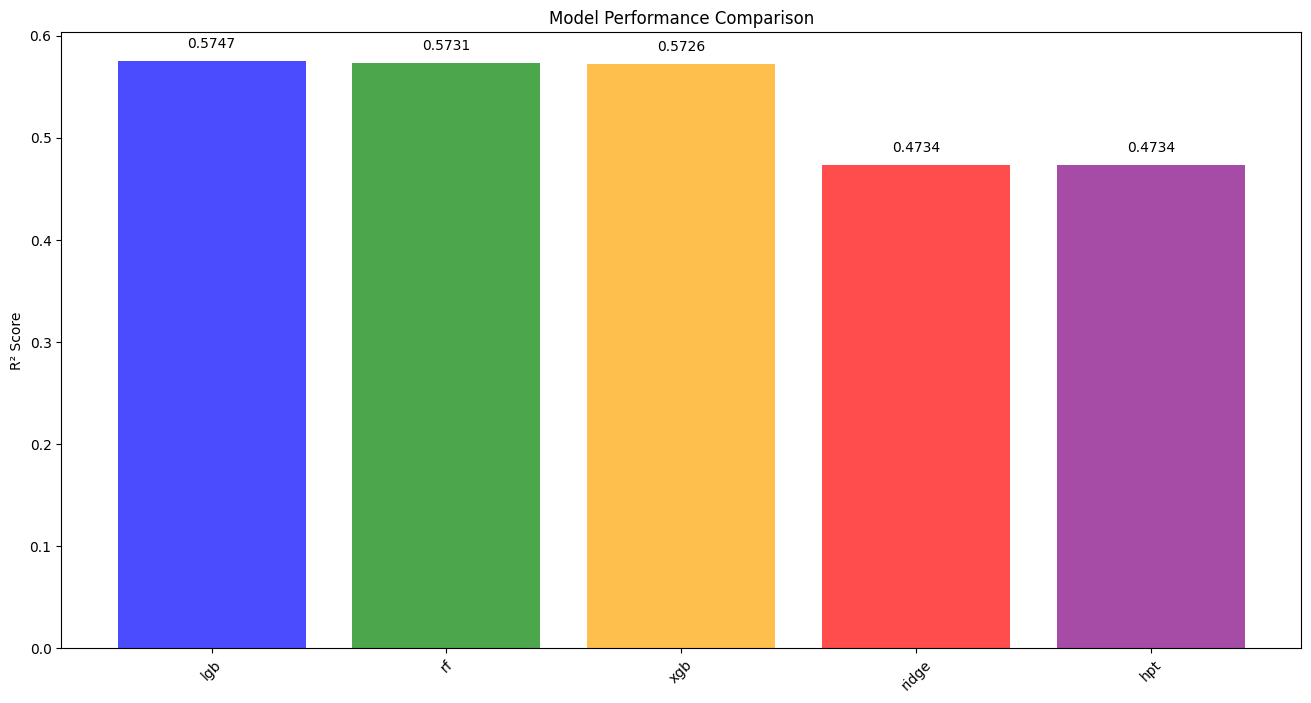

In [29]:
# Model performance comparison
model_names = list(results2['model'].values)
r2_scores = results2['r2_val']
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.figure(figsize=(16,8))
bars = plt.bar(model_names, r2_scores, color=colors, alpha=0.7)
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.tick_params(axis='x', rotation=45)

for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.4f}', ha='center', va='bottom', fontsize=10)
plt.show()

In [30]:
# choosing pred strategy b/w "best" & "ensemble"
ML_choice = "best"

# best R2
if ML_choice == "best":
    best_model_name = results.loc[0,"model"]
    print("Using best ML model:", best_model_name)
    val_df["ml_pred"] = val_preds[best_model_name].values
    ensemble_ml_model = models[best_model_name]
else:
    # ensemble
    val_df["ml_pred"] = val_preds[["lgb","xgb","rf","ridge"]].mean(axis=1).values
    ensemble_ml_model = "ensemble_mean"
    print("Using ensemble mean of all ML models.")

print("ML val R2 (ensemble):", r2_score(y_val, val_df["ml_pred"]))


Using best ML model: lgb
ML val R2 (ensemble): 0.5747449427119653


In [31]:
# rule-based predictor
theater_dow_mean = df.groupby(["book_theater_id","dow"])["audience_count"].mean().to_dict()
theater_mean = df.groupby("book_theater_id")["audience_count"].mean().to_dict()
month_effect = (df.groupby("month")["audience_count"].mean() / (global_mean + 1e-9)).to_dict()

W = {
    "w_base": 0.72,
    "w_rolling_3": 0.025,
    "w_rolling_5": 0.035,
    "w_rolling_7": 0.06,
    "w_rolling_14": 0.028,
    "w_lag_1": 0.05,
    "w_lag_7": 0.036,
    "w_lag_14": 0.05,
    "w_tickets": 0.18,
    "w_ema": 0.04,
    "w_diff": 0.035,
    "w_momentum": 0.04,
    "w_weekend": 0.066,
    "w_month_effect": 0.056
}

def rule_based_pred(row):
    key = (row["book_theater_id"], int(row["dow"]))
    base = theater_dow_mean.get(key, theater_mean.get(row["book_theater_id"], global_mean))
    mfx = month_effect.get(int(row["month"]), 1.0)

    d1 = row.get("diff1", np.nan)
    d7 = row.get("diff7", np.nan)
    diff_combo = np.nanmean([d1, d7])
    if np.isnan(diff_combo):
        diff_combo = 0.0

    def sget(c, fallback):
        v = row.get(c, fallback)
        return fallback if pd.isna(v) else v

    r3 = sget("rolling_3", base)
    r5 = sget("rolling_5", base)
    r7 = sget("rolling_7", base)
    r14 = sget("rolling_14", base)
    l1 = sget("lag_1", base)
    l7 = sget("lag_7", base)
    l14 = sget("lag_14", base)
    ema = sget("ema_7", base)
    tickets = sget("tickets_booked", 0.0)
    momentum = sget("momentum", 0.0)
    is_wknd = int(row.get("is_weekend", 0))

    pred = (
        W["w_base"] * base
        + W["w_rolling_3"] * r3
        + W["w_rolling_5"] * r5
        + W["w_rolling_7"] * r7
        + W["w_rolling_14"] * r14
        + W["w_lag_1"] * l1
        + W["w_lag_7"] * l7
        + W["w_lag_14"] * l14
        + W["w_tickets"] * tickets
        + W["w_ema"] * ema
        + W["w_diff"] * diff_combo
        + W["w_momentum"] * momentum * base
        + W["w_weekend"] * is_wknd * r7
        + W["w_month_effect"] * (mfx - 1.0) * base
    )
    return pred

train_df["rule_pred"] = train_df.apply(rule_based_pred, axis=1)
val_df["rule_pred"] = val_df.apply(rule_based_pred, axis=1)

print("Rule val R2:", r2_score(val_df[target], val_df["rule_pred"]))
print("ML val R2 (ensemble):", r2_score(val_df[target], val_df["ml_pred"]))


Rule val R2: 0.6287283105979096
ML val R2 (ensemble): 0.5747449427119653


In [32]:
# 60% ML + 40% Rule
val_df["blended_pred"] = 0.6 * val_df["ml_pred"] + 0.4 * val_df["rule_pred"]
r2_rule = r2_score(val_df[target], val_df["rule_pred"])
r2_ml   = r2_score(val_df[target], val_df["ml_pred"])
r2_blend = r2_score(val_df[target], val_df["blended_pred"])

print(f"R2 Rule: {r2_rule:.4f}")
print(f"R2 ML  : {r2_ml:.4f}")
print(f"R2 Blend: {r2_blend:.4f}")

R2 Rule: 0.6287
R2 ML  : 0.5747
R2 Blend: 0.6265


# 8. Submission

In [33]:
# preparing features for submission df
submission = sample_submission.copy()
parts = submission["ID"].str.split("_", expand=True)
if parts.shape[1] >= 3:
    # ID like book_00001_2024-03-01
    submission["book_theater_id"] = parts[1].astype(str).apply(lambda x: f"book_{x}" if not str(x).startswith("book_") else x)
    submission["show_date"] = parts[2]
else:
    extraction = submission["ID"].str.extract(r'(?P<theater>book_[0-9]+)_(?P<date>\d{4}-\d{2}-\d{2})')
    submission["book_theater_id"] = extraction["theater"]
    submission["show_date"] = extraction["date"]

submission["show_date"] = pd.to_datetime(submission["show_date"], errors="coerce")
submission["dow"] = submission["show_date"].dt.dayofweek
submission["month"] = submission["show_date"].dt.month
submission["is_weekend"] = submission["dow"].isin([5,6]).astype(int)

# mapping last known features from df
last = df.sort_values(["book_theater_id","show_date"]).groupby("book_theater_id").last()

map_cols = ["lag_1","lag_2","lag_7","lag_14","rolling_3","rolling_5","rolling_7","rolling_14","rolling_30","ema_7","momentum","tickets_booked"]
for c in map_cols:
    submission[c] = submission["book_theater_id"].map(last[c] if c in last.columns else {}).fillna(global_mean)

# ensure all ML features exist in submission (fill with global_mean)
for c in active_features:
    if c not in submission.columns:
        submission[c] = global_mean

In [34]:
print("Generating submission predictions...")

X_sub = submission[active_features].astype(float)

# ---------- ML Prediction ----------
if ML_choice == "best":
    
    if best_model_name == "lgb":
        submission["ml_pred"] = models["lgb"].predict(X_sub)
    else:
        submission["ml_pred"] = models[best_model_name].predict(X_sub)

else:
    # ensemble of all models
    preds = {}
    preds["lgb"]   = models["lgb"].predict(X_sub)
    preds["xgb"]   = models["xgb"].predict(X_sub)
    preds["rf"]    = models["rf"].predict(X_sub)
    preds["ridge"] = models["ridge"].predict(X_sub)

    submission["ml_pred"] = (
        preds["lgb"] +
        preds["xgb"] +
        preds["rf"] +
        preds["ridge"]
    ) / 4.0


# Rule Predictions
submission["rule_pred"] = submission.apply(rule_based_pred, axis=1)


# Final Blend
submission["final_pred"] = (
    0.3 * submission["ml_pred"] +
    0.7 * submission["rule_pred"]
).clip(lower=0)


# Smoothing 
submission = submission.sort_values(["book_theater_id", "show_date"])
submission["final_smoothed"] = submission.groupby("book_theater_id")["final_pred"].transform(lambda s: s.rolling(3, min_periods=1).mean())


# Final rounding
submission["audience_count"] = (
    submission["final_smoothed"]
    .round()
    .astype(int)
    .clip(lower=0)
)


# Saving
submission[["ID", "audience_count"]].to_csv(output_path, index=False)

print("Saved blended submission:", output_path)
print("Prediction stats → min:", submission["audience_count"].min(),
      "max:", submission["audience_count"].max(),
      "mean:", submission["audience_count"].mean())
print(submission.head())

print("\n=== SUBMISSION COMPLETED SUCCESSFULLY ===")

Generating submission predictions...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Saved blended submission: /kaggle/working/submission.csv
Prediction stats → min: 5 max: 146 mean: 44.962508538700014
                      ID  audience_count book_theater_id  show_date  dow  \
0  book_00001_2024-03-01              41      book_00001 2024-03-01    4   
1  book_00001_2024-03-02              49      book_00001 2024-03-02    5   
2  book_00001_2024-03-03              50      book_00001 2024-03-03    6   
3  book_00001_2024-03-04              47      book_00001 2024-03-04    0   
4  book_00001_2024-03-06              41      book_00001 2024-03-06    2   

   month  is_weekend  lag_1  lag_2  lag_7  ...  rolling_30      ema_7  \
0      3           0   16.0   54.0   14.0  ...   37.980333  38.716214   
1      3           1   16.0   54.0   14.0  ...   37.980333  38.716214   
2      3           1   16.0   54.0   14.0  ...

In [41]:
submission["audience_count"].describe().T

count    38062.000000
mean        44.962509
std         22.916969
min          5.000000
25%         27.000000
50%         41.000000
75%         60.000000
max        146.000000
Name: audience_count, dtype: float64

# Code for Milestone1 starts

In [35]:

# Code for Milestone1 starts

#import pandas as pd
#df = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")



#df.shape

#cinePOS_theaters
#df_2 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")


#df_2.iloc[0:1].dtypes

#booknow_theaters
#df_3 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")


#df_3.head()

#df_3['theater_type'].unique()

#df_3['theater_type'].max()

#cinePOS_booking
#df_4 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")


#df_4.head()

#df_4['cine_theater_id'].unique().shape


#Combine the datasets booknow_booking and booknow_theaters(df_3).
#df_5 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")


#df_booking_cine_joined = df_5.join(df_3,how="inner",lsuffix="df_5",rsuffix="df_3")
#df_booking_cine_joined = df_5.join(df_3.set_index("book_theater_id"),on="book_theater_id")

#df_booking_cine_joined.shape

# how many distinct areas are the theaters located in?
#df_booking_cine_joined['theater_area'].unique().shape

#**Combine the datasets movie_theater_id_relation, cinePOS_booking(df_4) and cinePOS_theaters(df_2). Enter the column names containing missing values as comma seperated values**

#df_6 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")

#merged_1 = df_6.merge(df_4, on="cine_theater_id", how="inner")

#df_booking_cine_joined_on_id = merged_1.merge(df_2, on="cine_theater_id", how="inner")


#df_booking_cine_joined_on_id.head()

#df_booking_cine_joined_on_id.isna().any()

# Enter the date range spanned in the dataset named booknow_booking(df_5). 

# Hint: Find the earliest and latest date for which data is available in this dataset. 

#**Note: Enter the answer as "dd-mm-yyyy to dd-mm-yyyy"**

#df_5.iloc[0:1].dtypes

#df_5["show_datetime"] = pd.to_datetime(df_5["show_datetime"])
#df_5["booking_datetime"] = pd.to_datetime(df_5["booking_datetime"])

#df_5.iloc[0:1].dtypes

#earliest_date = df_5["show_datetime"].min().date()
#latest_date = df_5["show_datetime"].max().date()
#print(earliest_date)
#print(latest_date)

#print(f"{earliest_date.strftime('%d-%m-%Y')} to {latest_date.strftime('%d-%m-%Y')}")

#earliest_date_booking = df_5["booking_datetime"].min().date()
#latest_date_booking = df_5["booking_datetime"].max().date()
#print(earliest_date_booking)
#print(latest_date_booking)

#**Enter the date range spanned in the test dataset (sample_submission).**

#**Hint: Find the earliest and latest date for which data is available in this dataset.**

#**Note: Enter the answer as "dd-mm-yyyy to dd-mm-yyyy".**

#df_7 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")

#df_7["date"] = df_7["ID"].str[-10:]
#df_7["date"] = pd.to_datetime(df_7["date"])
#df_7.head()

#df_7.iloc[0:1].dtypes


# Find earliest and latest date
#earliest_date_sample = df_7["date"].min().date()
#latest_date_sample = df_7["date"].max().date()

#print(f"{earliest_date_sample.strftime('%d-%m-%Y')} to {latest_date_sample.strftime('%d-%m-%Y')}")


# Code for Milestone1 ends

# Code for Milestone1 ends

# Code for Milestone2 starts

In [36]:
# Code for Milestone2 starts

#Q1.In the booknow_booking.csv file, how many total booking records (rows) were made on the same calendar day as the show's date?

#Note: The question refers to day / date and not datetime

#import pandas as pd
#df_booknow_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")


#df_booknow_booking['show_datetime'] = pd.to_datetime(df_booknow_booking['show_datetime'])
#df_booknow_booking['booking_datetime'] = pd.to_datetime(df_booknow_booking['booking_datetime'])


#same_day_bookings = df_booknow_booking[df_booknow_booking['show_datetime'].dt.date == df_booknow_booking['booking_datetime'].dt.date]


#total_same_day = same_day_bookings.shape[0]
#print("Total bookings made on the same day as the show:", total_same_day)

#**Ans1.Total bookings made on the same day as the show: 20433**


#Q2.How many unique calendar months (e.g., Jan 2023, Feb 2023, ...) are present in the show_date column of the date_info.csv file?

#df_date_info = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")



#df_date_info['show_date'] = pd.to_datetime(df_date_info['show_date'])

#unique_months = df_date_info['show_date'].dt.to_period('M').nunique()

#print("Number of unique calendar months:", unique_months)

#**Number of unique calendar months: 18**

#Q3.What percentage of bookings in booknow_booking.csv were made on a Sunday?

#sundays = df_booknow_booking[df_booknow_booking['booking_datetime'].dt.dayofweek == 6]

#percentage_sundays = (sundays.shape[0] / df_booknow_booking.shape[0]) * 100

#print(f"Percentage of bookings made on a Sunday: {percentage_sundays:.2f}%")

#**Percentage of bookings made on a Sunday: 13.32%**

#Q4.In the booknow_theaters.csv file, if you decided to impute any missing latitude values by the mean latitude of only theaters with theater_type equal to Drama, what would be the imputation value?

#df_booknow_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")


#drama_theaters = df_booknow_theaters[df_booknow_theaters['theater_type'] == 'Drama']


#mean_latitude_drama = drama_theaters['latitude'].mean()

#print("Mean latitude for Drama theaters:", mean_latitude_drama)

#**Mean latitude for Drama theaters: 23.00090271008748**

#Q5.What is the range (Maximum - Minimum) of the latitude column in the booknow_theaters.csv file (rounded to 4 decimal places)?

#max_lat = df_booknow_theaters['latitude'].max()
#min_lat = df_booknow_theaters['latitude'].min()

#latitude_range = round(max_lat - min_lat, 4)

#print("Range of latitude:", latitude_range)

#**Range of latitude: 4.3235**

#Q6.To handle potential outliers in ticket sales, you decide to cap the tickets_sold column in cinePOS_booking.csv at the 95 th  percentile. Enter that value.

#df_cinePOS_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")


#percentile_95 = df_cinePOS_booking['tickets_sold'].quantile(0.95)

#print("95th percentile of tickets_sold:", percentile_95)

#**95th percentile of tickets_sold: 14.0**

#Q7.Appy OneHot Encoding on all the categorical columns of the dataset cinePOS_theaters.csv. What is the shape of the dataset after applying this transformation?

#Note: The result obtained highlights a potential drawback of OneHot encoding. Read about other forms of encoding and the advantages / disadvantages they offer.

#df_cinePOS_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")


#df_cinePOS_theaters.head()

#df_cinePOS_theaters.shape

#categorical_cols = ['cine_theater_id', 'theater_type', 'theater_area']


#df_encoded = pd.get_dummies(df_cinePOS_theaters, columns=categorical_cols, drop_first=False)


#encoded_shape = df_encoded.shape
#print("Shape after OneHot Encoding:", encoded_shape)

#**Shape after OneHot Encoding: (4690, 4814)**

# Code for Milestone2 ends

# **Milestone 3 Starts**

In [37]:
# Code For Milestone3 Starts

#**For this milestone, only the booknow_visits.csv file is to be used. Using the show_date column, create new columns for day, month, year and dayofyear. Once the new columns are created, drop the show_date column**

#**Split the data into X & y with the target variable audience_count as y and the remaining features as X.**

#**Split the dataset so that 20% of it is kept for validation. Ensure the split preserves the time series nature of the dataset. This data will be referred to as X_train, X_test and y_train, y_test**

#**Q1: What is the shape of X_train after making the said changes?**

#import pandas as pd
#df_booknow_visits = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")


#df_booknow_visits.head()

#df_booknow_visits['show_date'] = pd.to_datetime(df_booknow_visits['show_date'])

#df_booknow_visits['day'] = df_booknow_visits['show_date'].dt.day
#df_booknow_visits['month'] = df_booknow_visits['show_date'].dt.month
#df_booknow_visits['year'] = df_booknow_visits['show_date'].dt.year
#df_booknow_visits['dayofyear'] = df_booknow_visits['show_date'].dt.dayofyear

#df_booknow_visits = df_booknow_visits.drop(columns=['show_date'])

#X = df_booknow_visits.drop(columns=['audience_count'])
#y = df_booknow_visits['audience_count']

#split_index = int(0.8 * len(X))
#X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
#y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

#X_train.shape

#**(171236, 5)**

#**Use MinMaxScaler for the numerical columns & OneHotEncoding for the categorical columns. These transformations are to be applied on both the train & test datasets. Answer all the questions that follow.**

#**Q2 :Use LinearSVR for training and enter the r2_score obtained on the test dataset. Upto 3 decimal places**

#from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
#from sklearn.svm import LinearSVR
#from sklearn.metrics import r2_score,mean_absolute_error
#from sklearn.decomposition import TruncatedSVD"""

# Define column groups
#num_cols = ['day', 'month', 'year', 'dayofyear']
#cat_cols = ['book_theater_id']

# Define transformers
#scaler = MinMaxScaler()
#encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Combine into ColumnTransformer

#preprocessor = ColumnTransformer(
   # transformers=[
       # ('num', scaler, num_cols),
       # ('cat', encoder, cat_cols)
    #]
#) 


# Fit on train and transform both
#X_train_transformed = preprocessor.fit_transform(X_train)
#X_test_transformed = preprocessor.transform(X_test)

# Define and train LinearSVR model
#model = LinearSVR(random_state=42, max_iter=10000)


# Fit model on transformed training data
#model.fit(X_train_transformed, y_train)


# Predict on test data
#y_pred = model.predict(X_test_transformed)

# Compute R² score
#r2 = r2_score(y_test, y_pred)

#print("R² Score:", round(r2, 3))

#**R² Score: -0.000**

#**Q3 :Use TruncatedSVD with n_components = 4 and train LinearSVR again. What is the mean absolute error obtained on the training data? Upto 3 decimal places**

# Step 1: Apply TruncatedSVD on the transformed data
#svd = TruncatedSVD(n_components=4, random_state=42)

#X_train_svd = svd.fit_transform(X_train_transformed)
#X_test_svd = svd.transform(X_test_transformed)

# Step 2: Train LinearSVR on reduced data
#model_svd = LinearSVR(random_state=42, max_iter=10000)
#model_svd.fit(X_train_svd, y_train)

# Step 3: Predict on training data
#y_train_pred = model_svd.predict(X_train_svd)

#mae_train = mean_absolute_error(y_train, y_train_pred)

#print("Mean Absolute Error (Training):", round(mae_train, 3))

#**24.256**

#**Q4 :Based on the previous question, what is the r2_score obtained on the test data? Upto 3 decimal places**


# Predict on test data
#y_test_pred = model_svd.predict(X_test_svd)

# Compute R² score on test data
#r2_test = r2_score(y_test, y_test_pred)

#print("R² Score (Test):", round(r2_test, 3)) 

#**R² Score (Test): -0.023**

#**Q5 :Use SelectKBest with k = 2 , score_func = mutual_info_regression.  Based on attributes output by SelectKBest, what is the maximum score obtained?**

#from sklearn.feature_selection import SelectKBest, mutual_info_regression

#Initialize SelectKBest
#selector = SelectKBest(score_func=mutual_info_regression, k=2)

#  Fit selector on the transformed training data
#selector.fit(X_train_transformed, y_train)

# Get feature scores
#scores = selector.scores_

#import numpy as np


#max_score = np.max(scores)

#print("Maximum score obtained:", max_score)

#**Maximum score obtained: 0.025361270944430636**

#**Q6 : mean of scores**

# Compute mean
#mean_score = np.mean(scores)
#print("Maximum score obtained:", mean_score)

#**Maximum score obtained: 0.0011236967295620225**

#**Milestone 3 Ends**

[CV] END .model__learning_rate=0.06, model__n_estimators=800; total time=  16.4s
[CV] END .model__learning_rate=0.05, model__n_estimators=800; total time=  15.5s
[CV] END .model__learning_rate=0.06, model__n_estimators=800; total time=  16.2s
[CV] END .model__learning_rate=0.05, model__n_estimators=700; total time=  15.5s
[CV] END .model__learning_rate=0.06, model__n_estimators=700; total time=  16.4s
[CV] END .model__learning_rate=0.05, model__n_estimators=700; total time=  15.5s
[CV] END .model__learning_rate=0.06, model__n_estimators=700; total time=  16.5s
[CV] END .model__learning_rate=0.05, model__n_estimators=800; total time=  15.5s


# **Milestone 3 Ends**